# <p style="text-align: center;">Decision Trees</p>



## Objectives

This notebook has following objectives:

*   Develop a classification model using Decision Tree Algorithm


In this lab exercise, we will learn a popular machine learning algorithm, Decision Trees

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectives" data-toc-modified-id="Objectives-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectives</a></span></li><li><span><a href="#Import-the-libraries" data-toc-modified-id="Import-the-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import the libraries</a></span></li><li><span><a href="#Downloading-the-Data" data-toc-modified-id="Downloading-the-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Downloading the Data</a></span></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pre-processing</a></span></li><li><span><a href="#Setting-up-the-Decision-Tree" data-toc-modified-id="Setting-up-the-Decision-Tree-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Setting up the Decision Tree</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Prediction</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Visualization</a></span></li></ul></div>

## Import the libraries

In [52]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree


<div id="downloading_data"> 
    <h2>Downloading the Data</h2>
</div


In [53]:
path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv'
my_data = pd.read_csv(path, delimiter=",")
my_data.head(5)


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


The data set consists of 6 columns:  
* Age: Age of patient
* Sex: Gender of patient
* BP: Blood pressure of patient
* Cholesterol: Cholesterol of patient
* Na_to_K: Sodium to Potassium Ratio in Blood
* Drug: Drug Type

In [54]:
my_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


The data consists of 6 columns, 200 observations and no missing values. Drug column is the one we try to predict based on the first five columns.

We retrieve basic statistics for our data

In [55]:
my_data.describe()


,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [56]:
my_data.Sex.value_counts()


M    104
F     96
Name: Sex, dtype: int64

The majority of the patients are male

In [57]:
my_data.Cholesterol.value_counts()


HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

Cholesterol is either low or high

In [58]:
my_data.BP.value_counts()


HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64

And the BP has three options: low, normal or high

As for the target column, the drug, there are 5 options with the following count.

In [59]:
my_data.Drug.value_counts()


drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

We can throw a quick glimpse at drug counts based, for example, on sex:

In [60]:
my_data.groupby(["Drug", "Sex"]).size().reset_index(
    name="Count").sort_values(by='Count')


,Drug,Sex,Count
2,drugB,F,6
4,drugC,F,7
0,drugA,F,9
5,drugC,M,9
3,drugB,M,10
1,drugA,M,14
6,drugX,F,27
7,drugX,M,27
9,drugY,M,44
8,drugY,F,47


... or blood pressure

In [61]:
my_data.groupby(["Drug", "BP"]).size().reset_index(
    name="Count").sort_values(by='Count')


,Drug,BP,Count
1,drugB,HIGH,16
2,drugC,LOW,16
3,drugX,LOW,18
0,drugA,HIGH,23
7,drugY,NORMAL,23
6,drugY,LOW,30
4,drugX,NORMAL,36
5,drugY,HIGH,38


<div href="pre-processing">
    <h2>Pre-processing</h2>
</div>


Select the independent variables that will be used to predict the target one

In [62]:
X = my_data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]


array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.114],
       [28, 'F', 'NORMAL', 'HIGH', 7.798],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

Some features in this dataset are categorical, such as **Sex** or **BP**. The Decision Trees classification algorithm does not handle categorical variables. We can still convert these features to numerical values using **label encoder**
to convert the categorical variable into dummy/indicator variables.


In [63]:
from sklearn import preprocessing

# create an instance
le_sex = preprocessing.LabelEncoder()  
# fit the existing values
le_sex.fit(['F', 'M'])  
# transorm the data in the frame with the newly encoded values
X[:, 1] = le_sex.transform(X[:, 1])

le_BP = preprocessing.LabelEncoder()
le_BP.fit(['LOW', 'NORMAL', 'HIGH'])
X[:, 2] = le_BP.transform(X[:, 2])

le_Chol = preprocessing.LabelEncoder()
le_Chol.fit(['NORMAL', 'HIGH'])
X[:, 3] = le_Chol.transform(X[:, 3])

X[0:5]


array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

The categorical values are transormed, now we can fill the target variable.


In [64]:
y = my_data["Drug"]
y[0:5]


0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

<hr>

<div id="setting_up_tree">
    <h2>Setting up the Decision Tree</h2>
    We will be using <b>train/test split</b> on our <b>decision tree</b>. 
</div>


In [65]:
from sklearn.model_selection import train_test_split


Now <b> train_test_split </b> will return 4 different parameters. We will name them:<br>
X_trainset, X_testset, y_trainset, y_testset <br> <br>
The <b> train_test_split </b> will need the parameters: <br>
X, y, test_size=0.3, and random_state=3. <br> <br>
The <b>X</b> and <b>y</b> are the arrays required before the split, the <b>test_size</b> represents the ratio of the testing dataset, and the <b>random_state</b> ensures that we obtain the same splits.


In [66]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(
    X, y, test_size=0.3, random_state=3)


<hr>

<div id="modeling">
    <h2>Modeling</h2>
    We will first create an instance of the <b>DecisionTreeClassifier</b> called <b>drugTree</b>.<br>
    Inside of the classifier, we will use default hyperparameters.
</div>


In [67]:
drugTree = DecisionTreeClassifier()


Next, we will fit the data with the training feature matrix <b> X_trainset </b> and training  response vector <b> y_trainset </b>


In [68]:
drugTree.fit(X_trainset, y_trainset)


DecisionTreeClassifier()

<hr>

<div id="prediction">
    <h2>Prediction</h2>
    Let's make some <b>predictions</b> on the testing dataset and store it into a variable called <b>predTree</b>.
</div>


In [69]:
predTree = drugTree.predict(X_testset)


You can print out <b>predTree</b> and <b>y_testset</b> if you want to visually compare the predictions to the actual values.


In [70]:
print(predTree[0:5])
print(y_testset[0:5])


['drugY' 'drugX' 'drugX' 'drugX' 'drugX']
40     drugY
51     drugX
139    drugX
197    drugX
170    drugX
Name: Drug, dtype: object


<hr>

<div id="evaluation">
    <h2>Evaluation</h2>
    Next, let's import <b>metrics</b> from sklearn and check the accuracy of our model.
</div>


In [71]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))


DecisionTrees's Accuracy:  0.9833333333333333


Using Grid Search, we can experiment with different hyperparameters and see if we can improve the accuracy

In [72]:
from sklearn.model_selection import GridSearchCV

In [73]:
grid = {'max_depth':[1,2,3,4,5],
        'criterion':['gini','entropy']
       }

rf = DecisionTreeClassifier(random_state = 42)
rf_cv = GridSearchCV(rf,grid,cv=5)
rf_cv.fit(X_trainset,y_trainset)

print("Hyperparameters:",rf_cv.best_params_)
print("Train Score:",rf_cv.best_score_)
print("Test Score:",rf_cv.score(X_testset,y_testset))

Hyperparameters: {'criterion': 'gini', 'max_depth': 4}
Train Score: 0.9928571428571429
Test Score: 0.9833333333333333


The best performing results with 98% accuracy on the unseen data are delivered with the following hyperparameters: criterion: gini, max_depth: 4

<hr>

<div id="visualization">
    <h2>Visualization</h2>

Let's visualize the tree

</div>


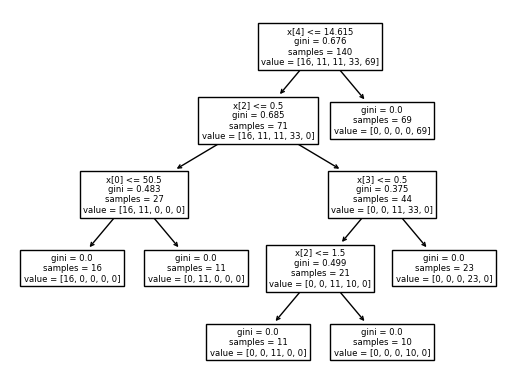

In [74]:
tree.plot_tree(drugTree)
plt.show()
